# 🛒 Favorita Grocery Sales Forecast

In this project, I forecast product sales for the region **Guayas** using the **Favorita Grocery Sales** dataset provided on Kaggle.  
I focus only on the **top 3 product families** and forecast sales for the period **January–March 2014**.

# 0. import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
import shutil
import zipfile
import py7zr
from kaggle.api.kaggle_api_extended import KaggleApi

install necessary packages

In [ ]:
# Install necessary packages (ensure this is done in notebook environment)
!pip install -q --disable-pip-version-check \
    kaggle \
    py7zr

# 1. Get the Data

To work with this dataset, I use the following libraries:

## 1.1 Download Data from KAGGLE

I use the Kaggle API to download and extract the competition data.

In [3]:
# Step 1: Move kaggle.json to the correct location
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)
kaggle_json_dest = os.path.join(kaggle_dir, "kaggle.json")
if not os.path.exists(kaggle_json_dest):
    shutil.move("kaggle.json", kaggle_json_dest)
os.chmod(kaggle_json_dest, 0o600)

# Step 2: Authenticate with Kaggle API
api = KaggleApi()
api.authenticate()

# Step 3: Create a folder for the project data
project_data_folder = "../data/retail_kaggle_data/"
os.makedirs(project_data_folder, exist_ok=True)

# Step 4: Download dataset zip from the Kaggle competition
api.competition_download_files("favorita-grocery-sales-forecasting", path=project_data_folder)

# Step 5: Unzip the downloaded archive
zip_path = os.path.join(project_data_folder, "favorita-grocery-sales-forecasting.zip")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(project_data_folder)

# Step 6: Extract all .csv.7z files
for filename in os.listdir(project_data_folder):
    if filename.endswith(".csv.7z"):
        full_path = os.path.join(project_data_folder, filename)
        with py7zr.SevenZipFile(full_path, mode='r') as archive:
            archive.extractall(path=project_data_folder)

print("✅ Dataset downloaded and extracted successfully!")

✅ Dataset downloaded and extracted successfully!


## 1.2 Load the Metadata

In [4]:
# Load the CSV files into pandas DataFrames
folder_path = "../data/retail_kaggle_data/"
df_stores = pd.read_csv(os.path.join(folder_path, 'stores.csv'))
df_items = pd.read_csv(os.path.join(folder_path, 'items.csv'))
df_transactions = pd.read_csv(os.path.join(folder_path, 'transactions.csv'))
df_oil = pd.read_csv(os.path.join(folder_path, 'oil.csv'))
df_holidays_events = pd.read_csv(os.path.join(folder_path, 'holidays_events.csv'))

# Optional: Load train.csv (large file, adjust if needed)
df_train = pd.read_csv(os.path.join(folder_path, 'train.csv'))

/var/folders/zs/s3r_n51s0j12n59b516vs7n00000gn/T/ipykernel_2186/3780809215.py:10: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(os.path.join(folder_path, 'train.csv'))


In [5]:
df_items.head(5)
# df_stores.head(5)
# df_transactions.head(5)
# df_oil.head(5)
# df_holidays_events.head(5)

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


## 1.3 Filter for Region "Guayas"

In [6]:
guayas_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

## 1.4 Load Train Data in Chunks (Filter Guayas)

In [8]:
filtered_chunks = []
chunk_size = 10 ** 6

for chunk in pd.read_csv("../data/retail_kaggle_data/train.csv", chunksize=chunk_size):
    chunk_filtered = chunk[chunk['store_nbr'].isin(guayas_ids)]
    filtered_chunks.append(chunk_filtered)

df_train = pd.concat(filtered_chunks, ignore_index=True)

/var/folders/zs/s3r_n51s0j12n59b516vs7n00000gn/T/ipykernel_2186/1213501986.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("../data/retail_kaggle_data/train.csv", chunksize=chunk_size):


In [ ]:
print("Shape of filtered df_train:", df_train.shape)


Shape of filtered df_train: (22941656, 6)


Now I will check, if the filtering after Guayas region was succesfull

How many stores are located in the 'Guayas' region and which Store Number they have?

In [9]:
print("The number of Stores in the Guayas region is:", df_train['store_nbr'].nunique())
print("The Store Numbers are:", df_train['store_nbr'].unique())


The number of Stores in the Guayas region is: 11
The Store Numbers are: [24 26 27 28 30 32 34 35 51 36 29]


# 2. Data Preparation

## 2.1 Merge with Item Families

In [10]:
df_train = df_train.merge(df_items[['item_nbr', 'family']], on='item_nbr', how='left')
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family
0,18789,2013-01-02,24,103665,6.0,NaN,BREAD/BAKERY
1,18790,2013-01-02,24,105574,12.0,NaN,GROCERY I
2,18791,2013-01-02,24,105575,2.0,NaN,GROCERY I
3,18792,2013-01-02,24,105577,1.0,NaN,GROCERY I
4,18793,2013-01-02,24,105693,7.0,NaN,GROCERY I


In [11]:
print("Filtered dataset – Shape:", df_train.shape)
print("Date range:", df_train['date'].min(), "to", df_train['date'].max())
print("Included families:", df_train['family'].nunique())


Filtered dataset – Shape: (22941656, 7)
Date range: 2013-01-02 to 2017-08-15
Included families: 33


## 2.2 Select Top 3 Product Families

In [12]:
top_families = df_train['family'].value_counts().nlargest(3).index
df_train = df_train[df_train['family'].isin(top_families)]

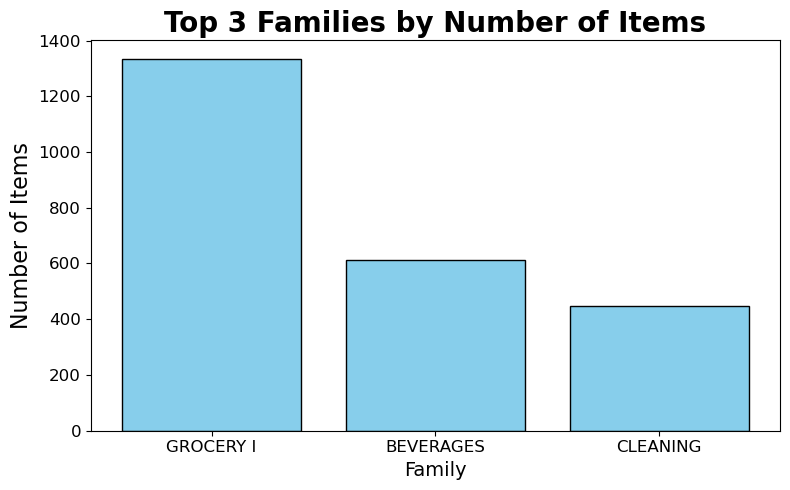

In [13]:
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)  # Keep only the top 3 families

# Plot the top 3 families
plt.figure(figsize=(8, 5))
plt.bar(top_3_families['Family'], top_3_families['Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 3 Families by Number of Items", fontsize=20, fontweight='bold')
plt.xlabel("Family", fontsize=14)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
plt.tight_layout()
# Display the plot
plt.show()

## 2.3 Random Sampling (2M rows)

In [14]:
#df_train = df_train.sample(n=2_000_000, random_state=42).reset_index(drop=True)

## 2.4 Convert Date

In [15]:
df_train['date'] = pd.to_datetime(df_train['date'])
# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()
# Get full date range
full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})
full_date_range

,date
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-06
...,...
1682,2017-08-11
1683,2017-08-12
1684,2017-08-13
1685,2017-08-14


## 2.4 Cross Join of each Store and Item combination for every day

In [16]:
# Create a DataFrame with all (store, item, date) combinations
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates()
all_combinations = store_item_combinations.merge(full_date_range, how='cross')
all_combinations

,store_nbr,item_nbr,date
0,24,105574,2013-01-02
1,24,105574,2013-01-03
2,24,105574,2013-01-04
3,24,105574,2013-01-05
4,24,105574,2013-01-06
...,...,...,...
35069351,51,2123791,2017-08-11
35069352,51,2123791,2017-08-12
35069353,51,2123791,2017-08-13
35069354,51,2123791,2017-08-14


In [17]:
df_filled = all_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left')
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)
df_filled['onpromotion'] = df_filled['onpromotion'].fillna(False).astype(int)

df_filled.head()

/var/folders/zs/s3r_n51s0j12n59b516vs7n00000gn/T/ipykernel_2186/3683109597.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filled['onpromotion'] = df_filled['onpromotion'].fillna(False).astype(int)


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,family
0,24,105574,2013-01-02,18790.0,12.0,0,GROCERY I
1,24,105574,2013-01-03,59692.0,1.0,0,GROCERY I
2,24,105574,2013-01-04,99664.0,3.0,0,GROCERY I
3,24,105574,2013-01-05,140805.0,4.0,0,GROCERY I
4,24,105574,2013-01-06,182800.0,7.0,0,GROCERY I


In [18]:
df_train = df_filled.copy()
del df_filled

# 3. Feature Engineering

## 3.1 Timebased Features

In [19]:
# Extract date features
df_train['day_of_week'] = df_train['date'].dt.dayofweek
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year

## 3.2 Lag Feature

In [20]:
# Calculating rolling average of unit_sales
df_train['unit_sales_7d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())
df_train['unit_sales_7d_avg'] = df_train['unit_sales_7d_avg'].fillna(0)


# 4. Data Cleaning

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35069356 entries, 0 to 35069355
Data columns (total 11 columns):
 #   Column             Dtype         
---  ------             -----         
 0   store_nbr          int64         
 1   item_nbr           int64         
 2   date               datetime64[ns]
 3   id                 float64       
 4   unit_sales         float64       
 5   onpromotion        int64         
 6   family             object        
 7   day_of_week        int32         
 8   month              int32         
 9   year               int32         
 10  unit_sales_7d_avg  float64       
dtypes: datetime64[ns](1), float64(3), int32(3), int64(3), object(1)
memory usage: 2.5+ GB


## 4.1 Handle Outliers

In [22]:
# Function to compute Z-scores within each (store_nbr, item_nbr) group
def add_z_scores(group: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a 'z_score' column to the group based on 'unit_sales'.
    If std deviation is zero, uses 1 to avoid division by zero.
    """
    mean = group['unit_sales'].mean()
    std = group['unit_sales'].std() or 1  # Avoid division by zero
    group['z_score'] = (group['unit_sales'] - mean) / std
    return group
# Apply Z-score calculation to each store-item group
df_train = df_train.groupby(['store_nbr', 'item_nbr']).apply(add_z_scores).reset_index(drop=True)

/var/folders/zs/s3r_n51s0j12n59b516vs7n00000gn/T/ipykernel_2186/2389567454.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby(['store_nbr', 'item_nbr']).apply(add_z_scores).reset_index(drop=True)


In [23]:
# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train[df_train['z_score'] > 5]
outliers

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,family,day_of_week,month,year,unit_sales_7d_avg,z_score
199,24,96995,2013-07-20,8561060.0,6.0,0,GROCERY I,5,7,2013,1.571429,6.770646
332,24,96995,2013-11-30,14742877.0,9.0,0,GROCERY I,5,11,2013,2.142857,10.303976
350,24,96995,2013-12-18,15666702.0,14.0,0,GROCERY I,2,12,2013,2.285714,16.192861
352,24,96995,2013-12-20,15768768.0,7.0,0,GROCERY I,4,12,2013,3.428571,7.948423
355,24,96995,2013-12-23,15928874.0,9.0,0,GROCERY I,0,12,2013,5.571429,10.303976
...,...,...,...,...,...,...,...,...,...,...,...,...
35067668,51,2123791,2017-08-15,125491523.0,1.0,0,GROCERY I,1,8,2017,0.142857,41.048759
35069327,51,2127114,2017-07-18,122560995.0,9.0,1,BEVERAGES,1,7,2017,1.428571,15.223260
35069333,51,2127114,2017-07-24,123189330.0,6.0,1,BEVERAGES,0,7,2017,2.142857,10.133755
35069341,51,2127114,2017-08-01,124029594.0,5.0,1,BEVERAGES,1,8,2017,1.000000,8.437254


## 4.2 Missing Values

In [24]:
# Check for missing
print(df_train.isnull().sum())

store_nbr                   0
item_nbr                    0
date                        0
id                   20323588
unit_sales                  0
onpromotion                 0
family               20323588
day_of_week                 0
month                       0
year                        0
unit_sales_7d_avg           0
z_score                     0
dtype: int64


In [25]:
# Step 1: Create a mapping from item_nbr to known family values (excluding NaNs)
item_family_map = df_train.dropna(subset=['family']).drop_duplicates(subset=['item_nbr'])[['item_nbr', 'family']]
item_family_dict = dict(zip(item_family_map['item_nbr'], item_family_map['family']))

# Step 2: Use the mapping to fill missing 'family' values based on 'item_nbr'
df_train['family'] = df_train['family'].fillna(df_train['item_nbr'].map(item_family_dict))
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,family,day_of_week,month,year,unit_sales_7d_avg,z_score
0,24,96995,2013-01-02,NaN,0.0,0,GROCERY I,2,1,2013,0.0,-0.296015
1,24,96995,2013-01-03,NaN,0.0,0,GROCERY I,3,1,2013,0.0,-0.296015
2,24,96995,2013-01-04,NaN,0.0,0,GROCERY I,4,1,2013,0.0,-0.296015
3,24,96995,2013-01-05,NaN,0.0,0,GROCERY I,5,1,2013,0.0,-0.296015
4,24,96995,2013-01-06,NaN,0.0,0,GROCERY I,6,1,2013,0.0,-0.296015


# 5. Exploratory Data Analysis (EDA)

## 5.1 General Overview

In [26]:
print("Shape:", df_train.shape)
print("Date Range:", df_train['date'].min(), "to", df_train['date'].max())
print("Top Families:", df_train['family'].unique())

Shape: (35069356, 12)
Date Range: 2013-01-02 00:00:00 to 2017-08-15 00:00:00
Top Families: ['GROCERY I' 'CLEANING' 'BEVERAGES']


## 5.2 Sales Over Time

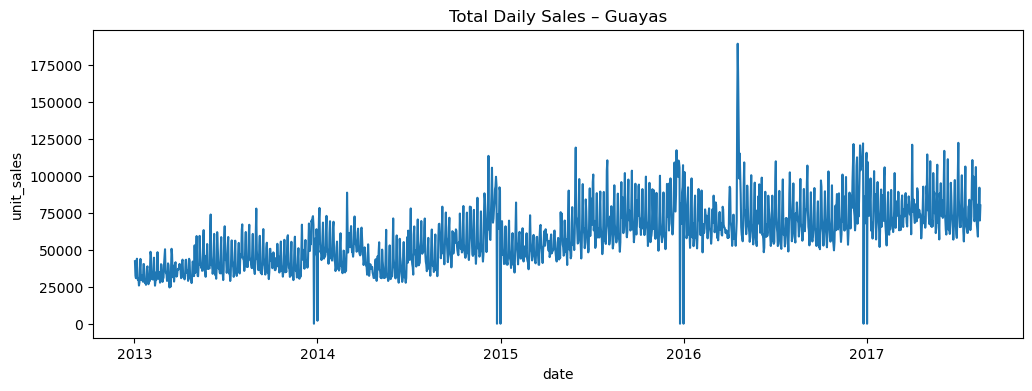

In [27]:
df_daily = df_train.groupby('date')['unit_sales'].sum().reset_index()
plt.figure(figsize=(12, 4))
sns.lineplot(data=df_daily, x='date', y='unit_sales')
plt.title("Total Daily Sales – Guayas")
plt.show()

## 5.3 Sales by Family

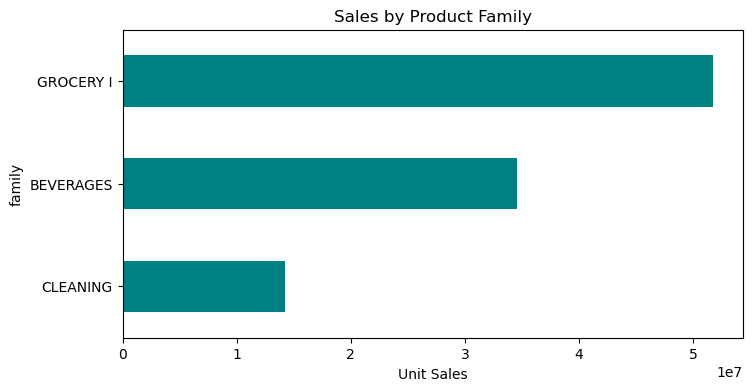

In [28]:
family_sales = df_train.groupby('family')['unit_sales'].sum().sort_values()
family_sales.plot(kind='barh', figsize=(8, 4), title="Sales by Product Family", color='teal')
plt.xlabel("Unit Sales")
plt.show()

## 5.4 Promotions Impact

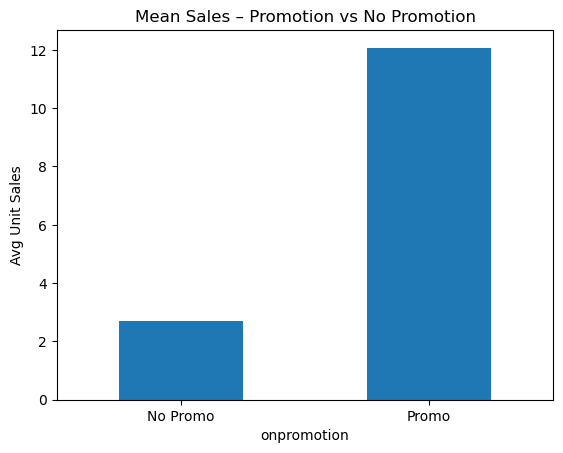

In [29]:
promo_sales = df_train.groupby('onpromotion')['unit_sales'].mean()
promo_sales.plot(kind='bar', title='Mean Sales – Promotion vs No Promotion')
plt.ylabel("Avg Unit Sales")
plt.xticks([0, 1], ['No Promo', 'Promo'], rotation=0)
plt.show()

5.5 Impact of Holidays

In [30]:
# Convert date column to datetime
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
print("Holidays range: from",df_holidays_events['date'].dt.date.min(),"till",df_holidays_events['date'].dt.date.max())

# Filtering out zero sales
df_train_no_zero = df_train[df_train.unit_sales > 0]

# Merge df_train_no_zero with df_holidays_events
df_train_holiday = pd.merge(df_train_no_zero, df_holidays_events, on='date', how='left')

# Aggregating sales by holiday and non-holiday
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

Holidays range: from 2012-03-02 till 2017-12-26


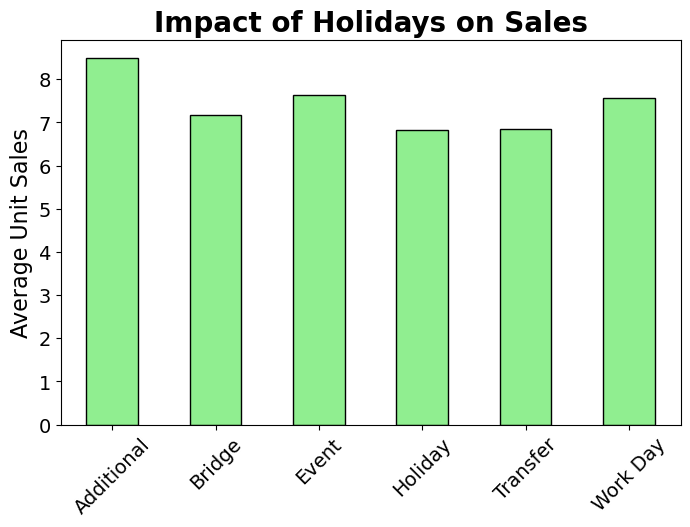

In [31]:
# Aggregating sales by holiday and non-holiday
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()
# Plotting holiday impact
plt.figure(figsize=(8,5))
holiday_sales.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Impact of Holidays on Sales', fontsize=20, fontweight='bold')
plt.ylabel('Average Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

## 5.5 Top 3 Product Families

In [32]:
top_families = df_train['family'].value_counts().nlargest(3).index.tolist()
print("Top 3 item families:", top_families)

Top 3 item families: ['GROCERY I', 'BEVERAGES', 'CLEANING']


Filter df_train on the top 3 families

In [33]:
df_train = df_train[df_train['family'].isin(top_families)]

In [34]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train[df_train['date'] < '2014-04-01']

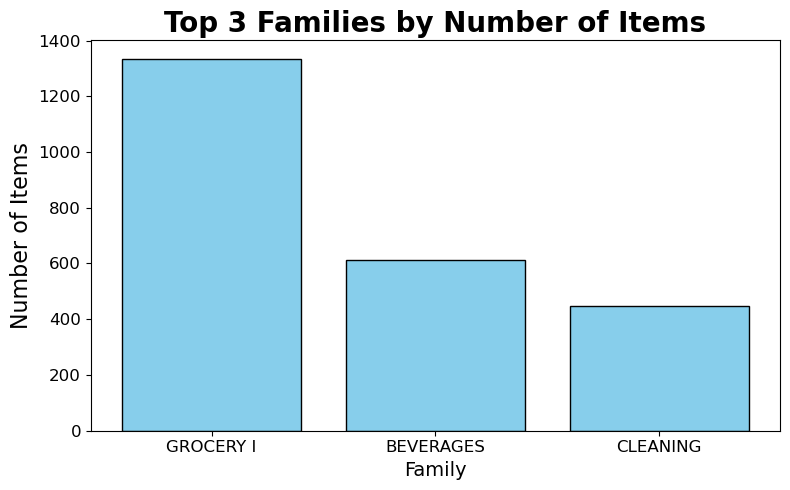

In [35]:
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)  # Keep only the top 3 families

# Plot the top 3 families
plt.figure(figsize=(8, 5))
plt.bar(top_3_families['Family'], top_3_families['Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 3 Families by Number of Items", fontsize=20, fontweight='bold')
plt.xlabel("Family", fontsize=14)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
plt.tight_layout()
# Display the plot
plt.show()

## 6. Save Prepared Data

In [36]:
df = df_train[['store_nbr', 'item_nbr', 'date', 'unit_sales', 'onpromotion','family', 'day_of_week', 'month', 'year', 'unit_sales_7d_avg']]

In [37]:
df.to_csv("../data/preprocessed_data/train_guayas_prepared.csv", index=False)